In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from neo4j import GraphDatabase

In [2]:
DB_ULR = os.getenv("PAYSIM_URL")
DB_USER = os.getenv("PAYSIM_USER")
DB_PASS = os.getenv("PAYSIM_PASSWORD")
DB_NAME = os.getenv("PAYSIM_DB_NAME")
DB_ENCRYPTED = True


In [3]:
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS), encrypted=DB_ENCRYPTED)

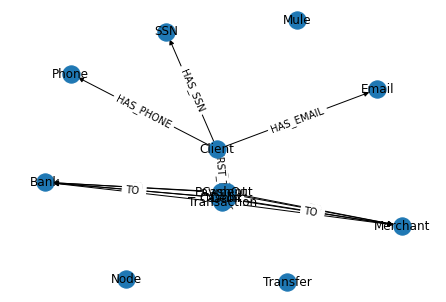

In [4]:
# Show schema
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        call db.schema.visualization()
        """
        ).data()
    )
    G = nx.MultiDiGraph()

    nodes = list(result[0]['nodes'])
    for node in nodes:
        G.add_node(node['name'], labels=node['name'])

    rels = list(result[0]['relationships'])
    for rel in rels:
        G.add_edge(rel[0]['name'], rel[2]['name'], key=rel[1], type=rel[1])

    edge_labels = nx.get_edge_attributes(G,'type')
    formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels}

    fig=plt.figure()
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
    nx.draw_networkx_edge_labels(G,pos=pos, edge_labels=formatted_edge_labels ) 



In [5]:
# Get statistics
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (t:Transaction)
        WITH sum(t.amount) AS globalSum, count(t) AS globalCnt
        WITH *, 10^3 AS scaleFactor
        UNWIND ['CashIn', 'CashOut', 'Payment', 'Debit', 'Transfer'] AS txType
        CALL apoc.cypher.run('MATCH (t:' + txType + ')
            RETURN sum(t.amount) as txAmount, count(t) AS txCnt', {})
        YIELD value
        RETURN txType,value.txAmount AS TotalMarketValue,
        100*round(scaleFactor*(toFloat(value.txAmount)/toFloat(globalSum)))
            /scaleFactor AS `%MarketValue`,
        100*round(scaleFactor*(toFloat(value.txCnt)/toFloat(globalCnt)))
            /scaleFactor AS `%MarketTransactions`,
        toInteger(toFloat(value.txAmount)/toFloat(value.txCnt)) AS AvgTransactionValue,
        value.txCnt AS NumberOfTransactions
        ORDER BY `%MarketTransactions` DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,txType,TotalMarketValue,%MarketValue,%MarketTransactions,AvgTransactionValue,NumberOfTransactions
0,CashIn,1.040582e+11,40.7,40.5,139347,746751
1,Payment,9.646814e+10,37.8,29.4,177840,542443
2,CashOut,5.385410e+10,21.1,23.0,126842,424574
3,Debit,1.016829e+09,0.4,7.1,7804,130284
4,Transfer,0.000000e+00,0.0,0.0,0,0


In [6]:
# Find clients with flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client)-[]->(t:Transaction)
        WHERE t.fraud=true
        RETURN c.name, COUNT(t) AS flagged_transactions ORDER BY flagged_transactions DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,flagged_transactions
0,Jackson Chavez,409
1,Taylor Slater,340
2,Leah Buchanan,288
3,Xavier Shepherd,281
4,Logan Miles,275
...,...,...
852,Sebastian Rutledge,2
853,Arianna Battle,2
854,Lucas Mcknight,2
855,Addison Slater,2


In [7]:
# Inmemory projection using cypher
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.graph.create.cypher(
            'client_graph', 
            'MATCH (c:Client) return id(c) as id', 
            'MATCH (c:Client)-[:PERFORMED]->(t)-[:TO]->(c2:Client) return id(c) as source, id(c2) as target, sum(t.amount) as amount, "TRANSACTED_WITH" as type '
        )
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (c:Client) return id(c) as id,MATCH (c:Client)-[:PERFORMED]->(t)-[:TO]->(c2:...,client_graph,11270,26035,290


In [8]:
# Louvain stats
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.stats('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0.509963,"[0.4295119439495274, 0.5099628902886598]",2,1452,"{'p99': 19, 'min': 1, 'max': 59, 'mean': 7.761...",5,0,587,"{'maxIterations': 10, 'seedProperty': None, 'c..."


In [9]:
# Save louvain results
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true,
            writeProperty:'LouvainCommunity'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,117,11270,0.513095,"[0.4299723809917578, 0.5130953844061168]",2,1474,"{'p99': 19, 'min': 1, 'max': 56, 'mean': 7.645...",4,0,461,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [10]:
# Find fraud rings ( louvain comminities)
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH DISTINCT(c.LouvainCommunity) as louvain_id, count(c) as num_members
        WHERE num_members > 5
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        RETURN louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        ORDER BY fraction_fraud DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,louvain_id,num_members,count_fraudsters,fraction_fraud
0,881,6,2,0.333333
1,602,10,3,0.300000
2,901,10,3,0.300000
3,650,11,3,0.272727
4,22,9,2,0.222222
...,...,...,...,...
143,825,16,1,0.062500
144,829,16,1,0.062500
145,98,17,1,0.058824
146,342,18,1,0.055556


In [11]:
# Create node embedding with FastRP
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.fastRP.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            relationshipWeightProperty:'amount',
            embeddingDimension:50, 
            writeProperty:'embedding'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,11270,11270,0,27,618,"{'writeConcurrency': 4, 'normalizationStrength..."


In [12]:
# Define our model data and also get the node embeddings back to python
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE c.is_fraudster=0 OR c.is_fraudster=1
            SET c:model_data
            RETURN c.embedding as embedding, c.is_fraudster as class
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    embedding = list(df['embedding'])
    category = list(df['class'])
    

,embedding,class
0,"[-0.07825742661952972, -0.33498385548591614, -...",1
1,"[0.1535114347934723, -0.047470588237047195, 0....",1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[-0.22373470664024353, -0.17217449843883514, -...",1
4,"[-0.29393425583839417, -0.07124979794025421, 0...",0
...,...,...
519,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
520,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
521,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
522,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [13]:
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 524 samples in 0.000s...
[t-SNE] Computed neighbors for 524 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 524 / 524
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.672867
[t-SNE] KL divergence after 1000 iterations: 0.978615


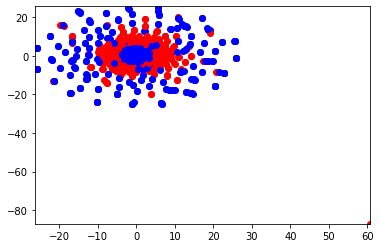

In [14]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot


for label, x, y in zip(category, x_coords, y_coords):
    if label == 0:
        plt.scatter(x, y, color='blue')
    else:
        plt.scatter(x, y, color='red')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


In [15]:
# Create projection with model data
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('fraud_graph',
            {
                Client:{
                    label:'model_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:0},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'triangles': {'prop...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",fraud_graph,524,0,100


In [16]:
# Train node classification & pick the best model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.train('fraud_graph', {
            nodeLabels: ['Client'],
            modelName: 'fraud-model',
            featureProperties: ['embedding', 'triangles','num_frauds','num_transactions','pageRank'], 
            targetProperty: 'is_fraudster', 
            metrics: ['F1_WEIGHTED','ACCURACY'], 
            holdoutFraction: 0.2, 
            validationFolds: 5, 
            randomSeed: 2,
            params: [
                {penalty: 0, maxIterations: 1000},
                {penalty: 0.5, maxIterations: 1000},
                {penalty: 1.0, maxIterations: 1000}
                ]
                }) YIELD modelInfo
            RETURN
            modelInfo.bestParameters AS winningModel,
            modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
            modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxIterations': 1000, 'penalty': 0}",0.757314,0.716659


In [17]:
# Label the data we want to make predictions on
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE NOT c:model_data SET c:predict_data
            return count(*)
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,count(*)
0,10746


In [18]:
# Create projection with predict_data 
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('predict_graph',
            {
                Client:{
                    label:'predict_data',
                    properties:{
                        embedding:{property:'embedding', defaultValue:0},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Client': {'properties': {'triangles': {'prop...,"{'TO': {'orientation': 'NATURAL', 'aggregation...",predict_graph,10746,0,125


In [19]:
# Make the predictions using node classification model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.predict.mutate('predict_graph', {
                nodeLabels: ['Client'], //filter our the character nodes
                modelName: 'fraud-model',
                mutateProperty: 'predicted_fraudster',
                predictedProbabilityProperty: 'predicted_fraud_probability'
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,21492,0,0,0,8,"{'modelName': 'fraud-model', 'predictedProbabi..."


In [20]:
# Write the predictions back to the database
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.writeNodeProperties(
                'predict_graph',
                ['predicted_fraudster', 'predicted_fraud_probability'],
                ['Client']
            )
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,172,predict_graph,"[predicted_fraud_probability, predicted_frauds...",21492


In [21]:
# Clean up gds graph and model catalogue 
with driver.session(database = DB_NAME) as session:
    session.read_transaction(lambda tx: 
        tx.run("CALL gds.beta.model.drop('fraud-model')").consume()
    )
    session.read_transaction(lambda tx: 
        tx.run("CALL gds.graph.drop('client_graph')").consume()
    )
    session.read_transaction(lambda tx: 
        tx.run("CALL gds.graph.drop('fraud_graph')").consume()
    )
    session.read_transaction(lambda tx: 
        tx.run("CALL gds.graph.drop('predict_graph')").consume()  
    )

In [22]:
# Clean up temporary labels and properties
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction(lambda tx: 
        tx.run("MATCH (c:model_data) remove c:model_data").consume()
    )
    result = session.read_transaction(lambda tx: 
        tx.run("MATCH (c:predict_data) remove c:predict_data").consume()
    )
    result = session.read_transaction(lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        remove  c.predicted_fraudster, 
                c.predicted_fraud_probability,
                c.embedding
        """).consume()
    )